In [5]:
!pip install --upgrade --user numpy matplotlib

  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/4d/1a/e85f0eea4cf03d6a0228f5c0256b53f2df4bc794706e7df019fc622e47f1/numpy-2.3.5-cp311-cp311-macosx_14_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.2 MB/s eta 0:00:00
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/e2/6a/d42588ad895279ff6708924645b5d2ed54a7fb2dc045c8a804e955aeace1/matplotlib-3.10.7-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 5.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 12.8 MB/s eta 0:00:0000:0100:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires

In [2]:
!pip install opencv-python ## need for importing cv2

In [1]:
import math, random, time
from collections import deque
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2  # for preprocessing

Matplotlib is building the font cache; this may take a moment.


In [2]:
## boards given by professor

PIXELS_PER_CELL = 12
DIRS = [(-1,0),(1,0),(0,-1),(0,1)]  # up, down, left, right

# ─────────── Layouts ───────────
tiny_walls = np.array(
    [[1,1,1,1,1,1,1],
     [1,0,0,0,0,0,1],
     [1,0,1,1,1,0,1],
     [1,0,1,0,1,0,1],
     [1,0,1,0,0,0,1],
     [1,0,0,0,1,0,1],
     [1,1,1,1,1,1,1]], dtype=int)

LAYOUTS = {
    "empty": np.zeros((7,7), dtype=int),
    "spiral": tiny_walls.copy(),
    "spiral_harder": tiny_walls.copy(),
}

classic_board = np.array([
 [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
 [1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1],
 [1,0,1,1,1,1,0,1,0,1,1,0,1,0,1,1,1,1,0,0,1],
 [1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1],
 [1,0,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,0,0,1],
 [1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1],
 [1,1,1,1,1,0,1,1,0,1,1,0,1,1,0,1,1,1,1,0,1],
 [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0],
 [1,1,1,1,1,0,1,1,0,1,1,0,1,1,0,1,1,1,1,0,1],
 [1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1],
 [1,0,1,1,1,1,0,1,0,1,1,0,1,0,1,1,1,1,0,0,1],
 [1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1],
 [1,0,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,0,0,1],
 [1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1],
 [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
], dtype=int)

LAYOUTS["classic"] = classic_board

COLOR_TABLE = np.array(
    [[0,0,0],[80,80,80],[255,255,0],[255,0,0],[0,255,0],[0,128,255]], dtype=np.uint8
)

# ───────── Pacman Environment ─────────
class PacmanEnv(gym.Env):
    metadata = {"render_modes": ["rgb_array"]}

    def __init__(self, layout="empty", render_mode=None):
        super().__init__()
        self.render_mode = render_mode
        self.layout_name = layout
        self.floor = LAYOUTS[layout]
        self.h, self.w = self.floor.shape
        self.img_h = self.h * PIXELS_PER_CELL
        self.img_w = self.w * PIXELS_PER_CELL

        self._build_tiles()

        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(0,255,shape=(self.img_h,self.img_w,3),dtype=np.uint8)
        self.rng = np.random.default_rng()
        self.reset()

    # ─────────── helpers ───────────
    def _legal_neighbours(self, x, y):
        return [(nx, ny) for dx, dy in DIRS
                if 0 <= (nx := x+dx) < self.h
                and 0 <= (ny := y+dy) < self.w
                and self.floor[nx, ny] == 0]

    # ─────────── reset ───────────
    def reset(self, *, seed=None, options=None):
        if seed is not None:
            self.rng = np.random.default_rng(seed)
        
        if self.layout_name == "empty":
            self.pac_pos = (0,0)
            self.ghost_pos = [(6,6)]
            self.pellets = [(0,6),(6,0)]
        elif self.layout_name == "spiral":
            self.pac_pos = (1,1)
            self.ghost_pos = [(5,5)]
            self.pellets = [(1,5),(5,1)]
        elif self.layout_name == "spiral_harder":
            self.pac_pos = (1,1)
            self.ghost_pos = [(3,3)]
            self.pellets = [(1,5),(5,1)]
        else:  # classic
            self.pac_pos = (13,10)
            self.ghost_pos = [(7,9),(7,11)]
            self.pellets = [(i,j) for i in range(self.h) for j in range(self.w)
                            if self.floor[i,j]==0 and (i,j) not in self.ghost_pos+[self.pac_pos]]

        self.first_ghost_move = True
        self.ghost_dir = [None]*len(self.ghost_pos)
        return self._render_board(), {}

    # ─────────── step ───────────
    def step(self, action:int):
        px, py = self.pac_pos
        if action==0: px=max(px-1,0)
        elif action==1: px=min(px+1,self.h-1)
        elif action==2: py=max(py-1,0)
        elif action==3: py=min(py+1,self.w-1)
        if self.floor[px,py]: px,py=self.pac_pos
        self.pac_pos=(px,py)

        reward, terminated = -0.1, False

        if self.pac_pos in self.ghost_pos:
            reward -=50
            terminated=True
            return self._render_board(), reward, terminated, False, {}

        if self.pac_pos in self.pellets:
            self.pellets.remove(self.pac_pos)
            reward +=10
            if not self.pellets:
                reward +=50
                terminated=True

        if not terminated:
            for g_idx,(gx,gy) in enumerate(self.ghost_pos):
                dir_ = self.ghost_dir[g_idx]
                if dir_ is None:
                    nx, ny = self.rng.choice(self._legal_neighbours(gx,gy))
                    self.ghost_dir[g_idx] = (nx-gx, ny-gy)
                    gx,gy=nx,ny
                else:
                    dx, dy = dir_
                    nx, ny = gx+dx, gy+dy
                    legal = self._legal_neighbours(gx,gy)
                    if (nx,ny) in legal and len(legal)==2:  # corridor-following
                        gx,gy=nx,ny
                    else:
                        candidates = [(lx-gx,ly-gy) for lx,ly in legal]
                        rev = (-dx,-dy)
                        if rev in candidates and len(candidates)>1: candidates.remove(rev)
                        dx,dy=self.rng.choice(candidates)
                        self.ghost_dir[g_idx]=(dx,dy)
                        gx,gy=gx+dx,gy+dy
                self.ghost_pos[g_idx]=(gx,gy)

            if self.pac_pos in self.ghost_pos:
                reward -=50
                terminated=True

        return self._render_board(), reward, terminated, False, {}

    # ─────────── tile builder ───────────
    def _build_tiles(self):
        s=PIXELS_PER_CELL
        cx=(s-1)/2
        yy,xx=np.mgrid[0:s,0:s]
        tiles=np.zeros((6,s,s,3),np.uint8)
        tiles[1]=[80,80,80]
        circle=(xx-cx)**2+(yy-cx)**2<=(s*0.48)**2
        mouth=np.abs(np.arctan2(yy-cx,xx-cx))<np.pi/5
        tiles[2][circle & ~mouth]=[255,255,0]

        def ghost_tile(rgb):
            g=np.zeros((s,s),bool)
            g|=(yy-4)**2+(xx-cx)**2<=25
            g|=yy>=4
            for col in range(0,s,4): g[s-1,col+2:col+4]=False
            tile=np.zeros((s,s,3),np.uint8)
            tile[g]=rgb
            for ex in (int(s*0.28),int(s*0.58)):
                ey=int(s*0.33)
                tile[ey:ey+3,ex:ex+2]=[255,255,255]
                tile[ey+1,ex+1]=[0,0,0]
            return tile

        tiles[3]=ghost_tile([255,0,0])
        tiles[5]=ghost_tile([0,128,255])
        p0=int(cx)-1
        tiles[4,p0:p0+2,p0:p0+2]=[0,255,0]

        self.tiles=tiles

    # ─────────── render ───────────
    def _render_board(self)->np.ndarray:
        board=np.zeros((self.h,self.w),np.uint8)
        board[self.floor==1]=1
        for x,y in self.pellets: board[x,y]=4
        for idx,(gx,gy) in enumerate(self.ghost_pos):
            board[gx,gy]=3 if idx==0 else 5
        px,py=self.pac_pos
        board[px,py]=2

        img=np.zeros((self.img_h,self.img_w,3),np.uint8)
        s=PIXELS_PER_CELL
        for i in range(self.h):
            for j in range(self.w):
                img[i*s:(i+1)*s,j*s:(j+1)*s]=self.tiles[board[i,j]]
        return img

    def render(self, mode="human"):
        if mode=="rgb_array":
            return self._render_board()
        plt.imshow(self._render_board())
        plt.axis("off")
        plt.show()

In [3]:
## creating pacman environments

from gymnasium.envs.registration import register

def register_pacman_envs():
    for layout in ["classic", "spiral", "spiral_harder", "empty"]:
        register(
            id=f"Pacman-{layout}-v0",
            entry_point=PacmanEnv,   # pass the class directly
            kwargs={"layout": layout},
            max_episode_steps=200
        )

register_pacman_envs()

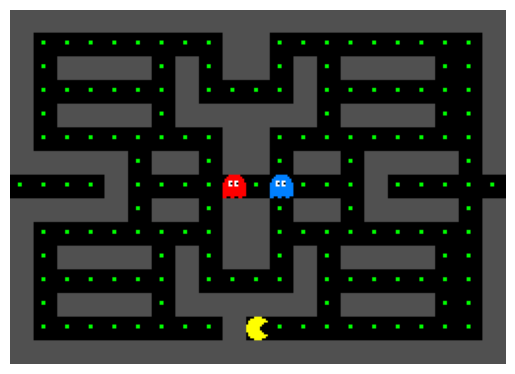

In [58]:
ENV_ID = "Pacman-classic-v0"
env = gym.make(ENV_ID, render_mode="rgb_array")
obs = env.reset()[0]
plt.imshow(obs)
plt.axis("off")
plt.show()

In [59]:
"""
raw image data from the pacman environment 
convert the rbg to grayscale then resize
then normalize 0-1

"""

import cv2
import torch

def preprocess_obs(obs, size=84):
    gray = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
    resized = cv2.resize(gray, (size, size), interpolation=cv2.INTER_AREA)
    tensor = torch.as_tensor(resized, dtype=torch.float32) / 255.0
    tensor = tensor.unsqueeze(0)
    return tensor

In [60]:
from collections import deque

class FrameStack:
    
    def __init__(self, k=4):
        self.k = k
        self.frames = deque(maxlen=k)

    def reset(self, obs): ## clears the frame at the start of the episode
        self.frames.clear()
        for _ in range(self.k):
            self.frames.append(preprocess_obs(obs))
        return torch.cat(list(self.frames), dim=0)

    def step(self, obs):
        self.frames.append(preprocess_obs(obs))
        return torch.cat(list(self.frames), dim=0)

In [61]:
import torch.nn as nn
import torch.nn.functional as F

"""
DDQ
using relu 
converts feature map to a 1d vec
dummy input avoids manually computing the dimension after convolutions.
value stream estimates the value of being in the current state V(s).
advantage stream estimates the advantage of each action over others A(s,a)

"""
class DuelingDQN(nn.Module):
    def __init__(self, in_channels, n_actions):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.Flatten()
        )
        # Compute conv output size with dummy input
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, 84, 84)
            conv_out = self.conv(dummy).shape[1]

        # Dueling streams
        self.fc_value = nn.Sequential(nn.Linear(conv_out, 512), nn.ReLU(), nn.Linear(512, 1))
        self.fc_adv = nn.Sequential(nn.Linear(conv_out, 512), nn.ReLU(), nn.Linear(512, n_actions))

    def forward(self, x):
        x = self.conv(x)
        value = self.fc_value(x)
        adv = self.fc_adv(x)
        return value + (adv - adv.mean(dim=1, keepdim=True))

In [152]:
## dqn

import torch.optim as optim
import random
import torch.nn.functional as F
from collections import deque

class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (torch.stack(states),
                torch.tensor(actions, dtype=torch.int64),
                torch.tensor(rewards, dtype=torch.float32),
                torch.stack(next_states),
                torch.tensor(dones, dtype=torch.float32))

    def __len__(self):
        return len(self.buffer)

class DQNAgent:
    def __init__(self, in_channels, n_actions, device=None, lr=1e-4,
                 gamma=0.99, batch_size=32, buffer_capacity=100000,
                 target_update_freq=1000, double=True):
        self.device = torch.device(device or ("cuda" if torch.cuda.is_available() else "cpu"))
        self.n_actions = n_actions
        self.gamma = gamma
        self.batch_size = batch_size
        self.double = double
        self.target_update_freq = target_update_freq

        self.policy = DuelingDQN(in_channels, n_actions).to(self.device)
        self.target = DuelingDQN(in_channels, n_actions).to(self.device)
        self.target.load_state_dict(self.policy.state_dict())
        self.target.eval()

        self.opt = optim.Adam(self.policy.parameters(), lr=lr)
        self.replay = ReplayBuffer(buffer_capacity)
        self.learn_steps = 0

    def select_action(self, state, epsilon=0.0):
        if random.random() < epsilon:
            return random.randrange(self.n_actions)  # Changed from self.env.action_space.n to self.n_actions
        with torch.no_grad():
            if state.ndim == 3:  # [C, H, W] - add batch dimension
                s = state.unsqueeze(0).to(self.device)
            elif state.ndim == 4:  # [batch, C, H, W] - already has batch dimension
                s = state.to(self.device)
            else:
                raise ValueError(f"Unexpected state dimension: {state.ndim}")
    
        q = self.policy(s)
        return int(q.argmax(dim=1).item())
        
        q = self.policy(s)
        return int(q.argmax(dim=1).item())

    def push(self, state, action, reward, next_state, done):
        self.replay.push(state.cpu(), action, reward, next_state.cpu(), done)

    def train_step(self):
        if len(self.replay) < max(1000, self.batch_size):
            return None
        s,a,r,ns,d = self.replay.sample(self.batch_size)
        s,ns,a,r,d = s.to(self.device), ns.to(self.device), a.to(self.device), r.to(self.device), d.to(self.device)
        q_val = self.policy(s).gather(1,a.unsqueeze(1))
        with torch.no_grad():
            if self.double:
                next_actions = self.policy(ns).argmax(1, keepdim=True)
                next_q = self.target(ns).gather(1, next_actions)
            else:
                next_q = self.target(ns).max(1, keepdim=True)[0]
            target = r.unsqueeze(1) + (1-d.unsqueeze(1)) * self.gamma * next_q
        loss = F.smooth_l1_loss(q_val, target)
        self.opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 10)
        self.opt.step()

        if self.learn_steps % self.target_update_freq == 0:
            self.target.load_state_dict(self.policy.state_dict())
        self.learn_steps += 1
        return loss.item()

In [153]:
# pacman_env.py
from __future__ import annotations
import math, random
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces

# ───────── rendering constants ─────────
PIXELS_PER_CELL = 12          # tile size

# ───────── 7×7 boards (unchanged) ───────
tiny_walls = np.array(
    [[1,1,1,1,1,1,1],
     [1,0,0,0,0,0,1],
     [1,0,1,1,1,0,1],
     [1,0,1,0,1,0,1],
     [1,0,1,0,0,0,1],
     [1,0,0,0,1,0,1],
     [1,1,1,1,1,1,1]], dtype=int)

LAYOUTS: dict[str, np.ndarray] = {
    "empty": np.zeros((7, 7), dtype=int),
    "spiral": tiny_walls.copy(),
    "spiral_harder": tiny_walls.copy(),
}

# ───────── classic 19×15 maze with corridors ─────────
classic_board = np.array([
 [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
 [1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1],
 [1,0,1,1,1,1,0,1,0,1,1,0,1,0,1,1,1,1,0,0,1],
 [1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1],
 [1,0,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,0,0,1],
 [1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1],
 [1,1,1,1,1,0,1,1,0,1,1,0,1,1,0,1,1,1,1,0,1],
 [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0],  # portals left/right (value 0)
 [1,1,1,1,1,0,1,1,0,1,1,0,1,1,0,1,1,1,1,0,1],
 [1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1],
 [1,0,1,1,1,1,0,1,0,1,1,0,1,0,1,1,1,1,0,0,1],
 [1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1],
 [1,0,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,0,0,1],
 [1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1],
 [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
], dtype=int)

LAYOUTS["classic"] = classic_board

# ───────── colour table (indices used in board array) ─────────
# 0 empty, 1 wall, 2 pac‑man, 3 red ghost, 4 pellet, 5 blue ghost
COLOR_TABLE = np.array(
    [[0,0,0],   [80,80,80], [255,255,0],
     [255,0,0], [0,255,0],  [0,128,255]], dtype=np.uint8)

DIRS = [(-1,0),(1,0),(0,-1),(0,1)]  # up, down, left, right

# ────────────────────────────────────────────────────────────────
class PacmanEnv(gym.Env):
    metadata = {"render_modes": ["rgb_array"]}

    # ───────────────────────────── init ─────────────────────────
    def __init__(self, layout: str = "empty"):
        super().__init__()
        if layout not in LAYOUTS:
            raise ValueError(layout)
        self.layout_name = layout
        self.floor = LAYOUTS[layout]          # 0/1 grid
        self.h, self.w = self.floor.shape     # board dims
        self.img_h = self.h * PIXELS_PER_CELL
        self.img_w = self.w * PIXELS_PER_CELL

        self._build_tiles()                   # pixel‑art sprites

        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(
            0, 255, shape=(self.img_h, self.img_w, 3), dtype=np.uint8
        )

        self.rng = np.random.default_rng()
        self.reset()

    # ───────────────────────── helpers ──────────────────────────
    def _legal_neighbours(self, x: int, y: int):
        out = []
        for dx, dy in DIRS:
            nx, ny = x + dx, y + dy
            if 0 <= nx < self.h and 0 <= ny < self.w and self.floor[nx, ny] == 0:
                out.append((nx, ny))
        return out

    # ───────────────────────── reset ────────────────────────────
    def reset(self, *, seed=None, options=None):
        if seed is not None:
            self.rng = np.random.default_rng(seed)

        if self.layout_name == "empty":
            self.pac_pos = (0, 0)
            self.ghost_pos = [(6, 6)]
            self.pellets = [(0, 6), (6, 0)]

        elif self.layout_name == "spiral":
            self.pac_pos = (1, 1)
            self.ghost_pos = [(5, 5)]
            self.pellets = [(1, 5), (5, 1)]

        elif self.layout_name == "spiral_harder":
            self.pac_pos = (1, 1)
            self.ghost_pos = [(3, 3)]
            self.pellets = [(1, 5), (5, 1)]

        else:  # classic
            self.pac_pos = (13, 10)           # lower middle corridor
            self.ghost_pos = [(7, 9), (7, 11)]  # red, blue
            # pellets everywhere except walls and starting positions
            self.pellets = [(i, j) for i in range(self.h) for j in range(self.w)
                            if self.floor[i, j] == 0 and
                               (i, j) not in self.ghost_pos + [self.pac_pos]]

        self.first_ghost_move = True                    # only used on "empty"
        self.ghost_dir: List[Tuple[int, int] | None] = [None] * len(self.ghost_pos)
        return self._render_board(), {}

    # ───────────────────────── step ────────────────────────────
    def step(self, action: int):
        # move Pac‑Man
        px, py = self.pac_pos
        if   action == 0: px = max(px-1, 0)
        elif action == 1: px = min(px+1, self.h-1)
        elif action == 2: py = max(py-1, 0)
        elif action == 3: py = min(py+1, self.w-1)
        if self.floor[px, py]: px, py = self.pac_pos
        self.pac_pos = (px, py)

        reward, terminated = -0.1, False
        
        # CHECK 1: Collision immediately after Pac-Man moves
        if self.pac_pos in self.ghost_pos:
            reward -= 50
            terminated = True
            return self._render_board(), reward, terminated, False, {}
        
        if self.pac_pos in self.pellets:
            self.pellets.remove(self.pac_pos); reward += 10
            if not self.pellets: reward += 50; terminated = True

        # move each ghost
        if not terminated:
            for g_idx, (gx, gy) in enumerate(self.ghost_pos):
                if self.layout_name == "empty":
                    if self.first_ghost_move:
                        gx, gy = self.rng.choice(self._legal_neighbours(gx, gy))
                        self.first_ghost_move = False
                    else:
                        dx, dy = px - gx, py - gy
                        if self.rng.random() < 0.7:
                            if abs(dx) > abs(dy): gx += int(math.copysign(1, dx))
                            elif dy:              gy += int(math.copysign(1, dy))
                        else:
                            gx += self.rng.choice([-1, 0, 1])
                            gy += self.rng.choice([-1, 0, 1])
                        gx = int(np.clip(gx, 0, self.h-1))
                        gy = int(np.clip(gy, 0, self.w-1))
                        if self.floor[gx, gy]:
                            gx, gy = self.ghost_pos[g_idx]

                else:  # corridor‑following ghost
                    dir_ = self.ghost_dir[g_idx]
                    if dir_ is None:
                        gx, gy = self.rng.choice(self._legal_neighbours(gx, gy))
                        self.ghost_dir[g_idx] = (gx - self.ghost_pos[g_idx][0],
                                                gy - self.ghost_pos[g_idx][1])
                    else:
                        dx, dy = dir_
                        nx, ny = gx + dx, gy + dy
                        if 0 <= nx < self.h and 0 <= ny < self.w and self.floor[nx, ny] == 0:
                            legal = self._legal_neighbours(gx, gy)
                            corridor = len(legal) == 2 and (nx, ny) in legal
                            if corridor:
                                gx, gy = nx, ny
                            else:
                                candidates = [(lx - gx, ly - gy) for lx, ly in legal]
                                rev = (-dx, -dy)
                                if len(candidates) > 1 and rev in candidates:
                                    candidates.remove(rev)
                                dx, dy = self.rng.choice(candidates)
                                self.ghost_dir[g_idx] = (dx, dy)
                                gx, gy = gx + dx, gy + dy
                        else:
                            legal = self._legal_neighbours(gx, gy)
                            dx, dy = self.rng.choice([(lx - gx, ly - gy) for lx, ly in legal])
                            self.ghost_dir[g_idx] = (dx, dy)
                            gx, gy = gx + dx, gy + dy

                self.ghost_pos[g_idx] = (gx, gy)

            # CHECK 2: Final collision check after all ghosts move
            if self.pac_pos in self.ghost_pos:
                reward -= 50
                terminated = True

        return self._render_board(), reward, terminated, False, {}

    # ──────────────────────── tile builder ─────────────────────
    def _build_tiles(self):
        """Build 12×12 pixel‑art tiles: 0 empty, 1 wall, 2 pac, 3 red ghost, 4 pellet, 5 blue ghost."""
        s = PIXELS_PER_CELL
        cx = (s - 1) / 2
        yy, xx = np.mgrid[0:s, 0:s]
        tiles = np.zeros((6, s, s, 3), dtype=np.uint8)

        # wall
        tiles[1, :, :, :] = [80, 80, 80]

        # pac‑man
        circle = (xx - cx) ** 2 + (yy - cx) ** 2 <= (s * 0.48) ** 2
        mouth  = np.abs(np.arctan2(yy - cx, xx - cx)) < np.pi / 5
        tiles[2, circle & ~mouth] = [255, 255, 0]

        # helper to build ghost (red then blue)
        def ghost_tile(rgb):
            g = np.zeros((s, s), bool)
            g |= (yy - 4) ** 2 + (xx - cx) ** 2 <= 25  # round head
            g |= yy >= 4                               # body
            for col in range(0, s, 4):                 # legs
                g[s - 1, col + 2:col + 4] = False
            tile = np.zeros((s, s, 3), np.uint8)
            tile[g] = rgb
            for ex in (int(s * 0.28), int(s * 0.58)):
                ey = int(s * 0.33)
                tile[ey:ey + 3, ex:ex + 2] = [255, 255, 255]  # whites
                tile[ey + 1, ex + 1] = [0, 0, 0]              # pupil
            return tile

        tiles[3] = ghost_tile([255, 0, 0])     # red
        tiles[5] = ghost_tile([0, 128, 255])   # blue

        # pellet
        p0 = int(cx) - 1
        tiles[4, p0:p0 + 2, p0:p0 + 2] = [0, 255, 0]

        self.tiles = tiles

    # ──────────────────────── rendering ────────────────────────
    def _render_board(self) -> np.ndarray:
        board = np.zeros((self.h, self.w), np.uint8)
        board[self.floor == 1] = 1
        for (x, y) in self.pellets: board[x, y] = 4
        for idx, (gx, gy) in enumerate(self.ghost_pos):
            board[gx, gy] = 3 if idx == 0 else 5
        px, py = self.pac_pos
        board[px, py] = 2

        img = np.zeros((self.img_h, self.img_w, 3), np.uint8)
        s = PIXELS_PER_CELL
        for i in range(self.h):
            for j in range(self.w):
                img[i*s:(i+1)*s, j*s:(j+1)*s] = self.tiles[board[i, j]]
        return img

    def render(self, mode="human"):
        if mode == "rgb_array":
            return self._render_board()
        plt.imshow(self._render_board()); plt.axis("off"); plt.show()



In [154]:
ENV_ID = "classic"
env = PacmanEnv(layout=ENV_ID)
obs = env.reset()[0]  # get the initial observation

In [155]:
## frame stack for the dqn, allows the last k (4) frames to stay
import numpy as np

class FrameStack:
    def __init__(self, k: int = 4):
        self.k = k
        self.frames = []

    def reset(self, obs):
        self.frames = [obs for _ in range(self.k)]
        return np.concatenate(self.frames, axis=2)

    def append(self, obs):
        self.frames.pop(0)
        self.frames.append(obs)
        return np.concatenate(self.frames, axis=2)

In [156]:
fs = FrameStack(k=4)
obs, _ = env.reset()
state = fs.reset(obs)

In [157]:
obs, _ = env.reset()
state = fs.reset(obs)

in_channels = state.shape[2]
n_actions = env.action_space.n


agent = DQNAgent(in_channels=in_channels, n_actions=n_actions)

In [158]:
obs, _ = env.reset()
state = fs.reset(obs)

action = agent.select_action(state, epsilon=1.0)
next_obs, reward, done, _, _ = env.step(action)

next_state = fs.append(next_obs)

print("State shape:", state.shape)
print("Next state shape:", next_state.shape)

State shape: (180, 252, 12)
Next state shape: (180, 252, 12)


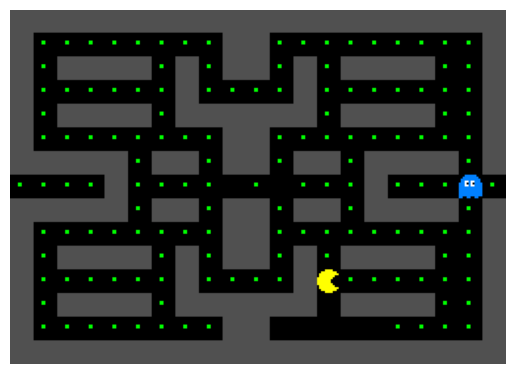

Total reward: 3.6999999999999176


In [163]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import torch
import random

mode = "dqn"

# Reset environment
obs, _ = env.reset()
state = fs.reset(obs)
done = False
total_reward = 0

plt.ion()

while not done:
    # Render
    clear_output(wait=True)
    plt.imshow(obs)
    plt.axis("off")
    plt.show()
    time.sleep(0.05)

    # Choose action
    if mode == "random":
        action = random.randrange(env.action_space.n)
    elif mode == "dqn":
        # Convert state to tensor
        state_tensor = torch.as_tensor(state, dtype=torch.float32)
        
        print(f"DEBUG - Original state shape: {state.shape}")
        print(f"DEBUG - Tensor shape: {state_tensor.shape}")
        
        if state_tensor.ndim == 3:
            state_tensor = state_tensor.permute(2, 0, 1)
        
        print(f"DEBUG - Final shape for DQN: {state_tensor.shape}")
        
        state_tensor = state_tensor.to(agent.device)
        
        action = agent.select_action(state_tensor, epsilon=1.0)
    else:
        raise ValueError("Invalid mode")

    next_obs, reward, done, _, _ = env.step(action)
    next_state = fs.append(next_obs)

    total_reward += reward
    state = next_state
    obs = next_obs

clear_output(wait=True)
plt.imshow(obs)
plt.axis("off")
plt.show()
print("Total reward:", total_reward)

plt.ioff()

In [164]:
import torch
import random
import torchvision.transforms as T

def evaluate_agent(env, agent, fs, num_episodes=100, mode="dqn"):
    wins = 0
    resize = T.Compose([T.ToPILImage(),
                       T.Resize((84, 84)),
                       T.ToTensor()])

    for ep in range(num_episodes):
        obs, _ = env.reset()
        state = fs.reset(obs)
        done = False

        while not done:
            if mode == "random":
                action = random.randrange(env.action_space.n)
            elif mode == "dqn":
                state_tensor = torch.as_tensor(state, dtype=torch.float32)
                if state_tensor.shape[0] != 84 or state_tensor.shape[1] != 84:
                    H, W, C = state_tensor.shape
                    resized_channels = []
                    for c in range(C):
                        channel_img = state_tensor[:, :, c].unsqueeze(0)
                        resized = resize(channel_img).squeeze(0)
                        resized_channels.append(resized)
                    
                    state_tensor = torch.stack(resized_channels, dim=2)
                
                state_tensor = state_tensor.permute(2, 0, 1).unsqueeze(0)
                
                state_tensor = state_tensor.to(agent.device)
                action = agent.select_action(state_tensor, epsilon=0.0)
            else:
                raise ValueError("Invalid mode")

            next_obs, reward, done, _, _ = env.step(action)
            state = fs.append(next_obs)

        if len(env.pellets) == 0:
            wins += 1

    win_rate = wins / num_episodes
    print(f"Win rate over {num_episodes} episodes: {win_rate*100:.2f}%")
    return win_rate

In [ ]:
evaluate_agent(env, agent, fs, num_episodes=50, mode="dqn")

In [ ]:
"""
classic 50 episodes:
empty 50 episodes:
spiral 50 episodes:
spiral hard 50 episodes: 
"""